<img src="https://www.reuters.com/resizer/TtkR2s31XJY7LUnvVRbiOUfOP_Q=/1200x0/filters:quality(80)/cloudfront-us-east-2.images.arcpublishing.com/reuters/HW2I6JF5GRMTDOBLEZUFJJY4NI.jpg" width=800 class="center">
<h1 align="center">Predict Binance Cryptocurrencies with PyTorch</h1>
<h2 align="center">Check the <a href="https://www.kaggle.com/datasets/alejopaullier/binance-dataset">dataset here</a></h2>
<h3 align="center">This notebook is adapted from  <a href="https://towardsdatascience.com/building-rnn-lstm-and-gru-for-time-series-using-pytorch-a46e5b094e7b">Kaan Kuguoglu great blog</a>. Go check it out!</h3>

<div style="padding:20px; 
            color:#150d0a;
            margin:10px;
            font-size:220%;
            text-align:center;
            display:fill;
            border-radius:20px;
            border-width: 5px;
            border-style: solid;
            border-color: #150d0a;
            background-color:#eca912;
            overflow:hidden;
            font-weight:500">Context</div>

<div style="padding:20px; 
            color:#150d0a;
            margin:10px;
            font-size:110%;
            display:fill;
            border-radius:10px;
            border-style: solid;
            border-color: #150d0a;
            background-color:#ecc257;
            overflow:hidden;
            font-weight:500">Binance is a cryptocurrency exchange which is the largest exchange in the world in terms of daily trading volume of cryptocurrencies. It was founded in 2017 and is registered in the Cayman Islands. Famous cryptocurrencies can be exchanged in the platform such as Bitcoin, Ethereum, Solana, etc. We can make use of Time Series Analysis algorithms to try to predict future prices of these cryptocurrencies.</div>
            
<div style="padding:20px; 
            color:#150d0a;
            margin:10px;
            font-size:220%;
            text-align:center;
            display:fill;
            border-radius:10px;
            border-style: solid;
            border-width: 5px;
            border-color: #150d0a;
            background-color:#eca912;
            overflow:hidden;
            font-weight:500">TL;DR</div>

<div style="padding:20px; 
            color:#150d0a;
            margin:10px;
            font-size:110%;
            display:fill;
            border-radius:10px;
            border-style: solid;
            border-color: #150d0a;
            background-color:#ecc257;
            overflow:hidden;
            font-weight:500">In this notebook we will be using data from the infamous cryptocurrency Luna. We will try to predict its price after its huge collapse in 9th May 2022. We will be using PyTorch for this notebook. For obvious reasons, the extracted data does not come from the collapse since this would be an outlier.
</div>
<div style="padding:20px; 
            color:#150d0a;
            margin:10px;
            font-size:220%;
            text-align:center;
            display:fill;
            border-radius:10px;
            border-style: solid;
            border-width: 5px;
            border-color: #150d0a;
            background-color:#eca912;
            overflow:hidden;
            font-weight:500">What you will learn in this notebook</div>

<div style="padding:20px; 
            color:#150d0a;
            margin:10px;
            font-size:110%;
            display:fill;
            border-radius:10px;
            border-style: solid;
            border-color: #150d0a;
            background-color:#ecc257;
            overflow:hidden;
            font-weight:500">
 <ol>
  <li>How to structure a univariate Time Series Analysis problem. This problem is formulated as a one-step time series forecasting.</li>
  <li>How to use cyclical features.</li>
  <li>How to use popular Time Series neural networks like LSTMs, RNNs and GRUs.</li>
  <li>How to perform Cross Validation on a Time Series Analysis problem.</li>
</ol>
</div>


# Import libraries

In [1]:
import datetime
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import time
import torch
import torch.nn as nn


from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import MaxAbsScaler, MinMaxScaler, RobustScaler, StandardScaler
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.utils.data import TensorDataset, DataLoader
from tqdm import tqdm

# Load data

In [2]:
df = pd.read_csv("../input/binance-dataset/binance-dataset.csv", sep=',')
print(f"Dataframe shape: {df.shape}")
df.head()

Dataframe shape: (5400, 16)


,open_time,open,high,low,close,volume,close_time,quote_asset_volume,number_of_trades,taker_buy_base_asset_volume,taker_buy_quote_asset_volume,ignore,open_time_utc,close_time_utc,open_time_min,close_time_min
0,1652400000000,0.00032,0.00049,0.00031,0.00047,4.032332e+08,1652400059999,163509.572433,1276,2.233801e+08,89172.973422,0,2022-05-13 00:00:00,2022-05-13 00:00:59,0,1
1,1652400060000,0.00047,0.00055,0.00042,0.00049,3.467135e+08,1652400119999,171487.017111,1691,1.722357e+08,85252.153831,0,2022-05-13 00:01:00,2022-05-13 00:01:59,1,2
2,1652400120000,0.00049,0.00052,0.00048,0.00051,2.064851e+08,1652400179999,103019.589015,976,1.127482e+08,56587.930244,0,2022-05-13 00:02:00,2022-05-13 00:02:59,2,3
3,1652400180000,0.00052,0.00059,0.00051,0.00058,2.723594e+08,1652400239999,152790.423528,1163,1.495032e+08,83916.042608,0,2022-05-13 00:03:00,2022-05-13 00:03:59,3,4
4,1652400240000,0.00057,0.00060,0.00032,0.00035,5.888936e+08,1652400299999,258685.424191,2566,2.240415e+08,100513.534527,0,2022-05-13 00:04:00,2022-05-13 00:04:59,4,5


### Drop columns

We will drop some columns which we will not be using in this notebook. We will try to predict only based on the opening price,

In [3]:
columns_to_drop = ['open_time',
                   'close_time',
                   'ignore', 
                   'close_time_utc',
                   'open_time_min',
                   'close_time_min']
df.drop(columns=columns_to_drop, inplace=True)
print(f"Dataframe shape: {df.shape}")
df.head()

Dataframe shape: (5400, 10)


,open,high,low,close,volume,quote_asset_volume,number_of_trades,taker_buy_base_asset_volume,taker_buy_quote_asset_volume,open_time_utc
0,0.00032,0.00049,0.00031,0.00047,4.032332e+08,163509.572433,1276,2.233801e+08,89172.973422,2022-05-13 00:00:00
1,0.00047,0.00055,0.00042,0.00049,3.467135e+08,171487.017111,1691,1.722357e+08,85252.153831,2022-05-13 00:01:00
2,0.00049,0.00052,0.00048,0.00051,2.064851e+08,103019.589015,976,1.127482e+08,56587.930244,2022-05-13 00:02:00
3,0.00052,0.00059,0.00051,0.00058,2.723594e+08,152790.423528,1163,1.495032e+08,83916.042608,2022-05-13 00:03:00
4,0.00057,0.00060,0.00032,0.00035,5.888936e+08,258685.424191,2566,2.240415e+08,100513.534527,2022-05-13 00:04:00


### Filter columns

In [4]:
df = df[["open", "open_time_utc"]]
df.set_index("open_time_utc", inplace=True)
df.index = pd.to_datetime(df.index)
print(f"Dataframe shape: {df.shape}")
df.head()

Dataframe shape: (5400, 1)


,open
open_time_utc,
2022-05-13 00:00:00,0.00032
2022-05-13 00:01:00,0.00047
2022-05-13 00:02:00,0.00049
2022-05-13 00:03:00,0.00052
2022-05-13 00:04:00,0.00057


# Using lagged observations as features

> ''*Let’s start with using time steps as features. In other words, we’re trying to predict the next value, X(t+n), from the previous n observations Xt, X+1, …, and X(t+n-1). Then, what we need to do is simply create n columns with the preceding observations. Luckily, Pandas provides the method shift() to shift the values in a column. So, we can write a for loop to create such lagged observations by shifting the values in a column by n times and removing the first n columns. Lagging is simple yet a good starting point, especially if you don’t have many features to work with at the start.''*

In [5]:
def generate_time_lags(df, n_lags):
    df_n = df.copy()
    for n in range(1, n_lags + 1):
        df_n[f"lag{n}"] = df_n["open"].shift(n)
    df_n = df_n.iloc[n_lags:]
    return df_n
    
input_dim = 60
df_copy = df.copy()
df = generate_time_lags(df, input_dim)
print(f"Dataframe shape: {df.shape}")
df.head()

Dataframe shape: (5340, 61)


,open,lag1,lag2,lag3,lag4,lag5,lag6,lag7,lag8,lag9,...,lag51,lag52,lag53,lag54,lag55,lag56,lag57,lag58,lag59,lag60
open_time_utc,,,,,,,,,,,,,,,,,,,,,
2022-05-13 01:00:00,0.000010,0.00001,0.00001,0.000011,0.000011,0.000012,0.000012,0.000016,0.000018,0.000016,...,0.00038,0.00033,0.00034,0.00033,0.00034,0.00057,0.00052,0.00049,0.00047,0.00032
2022-05-13 01:01:00,0.000010,0.00001,0.00001,0.000010,0.000011,0.000011,0.000012,0.000012,0.000016,0.000018,...,0.00033,0.00038,0.00033,0.00034,0.00033,0.00034,0.00057,0.00052,0.00049,0.00047
2022-05-13 01:02:00,0.000010,0.00001,0.00001,0.000010,0.000010,0.000011,0.000011,0.000012,0.000012,0.000016,...,0.00032,0.00033,0.00038,0.00033,0.00034,0.00033,0.00034,0.00057,0.00052,0.00049
2022-05-13 01:03:00,0.000010,0.00001,0.00001,0.000010,0.000010,0.000010,0.000011,0.000011,0.000012,0.000012,...,0.00025,0.00032,0.00033,0.00038,0.00033,0.00034,0.00033,0.00034,0.00057,0.00052
2022-05-13 01:04:00,0.000012,0.00001,0.00001,0.000010,0.000010,0.000010,0.000010,0.000011,0.000011,0.000012,...,0.00024,0.00025,0.00032,0.00033,0.00038,0.00033,0.00034,0.00033,0.00034,0.00057


# Generating features from timestamps

> ''*Despite its name, feature engineering is generally more art than science. Nonetheless, some rules of thumb can guide data scientists and the like. My goal in this section is not to go through all such practices here but to demonstrate a couple of them and let you experiment on your own. In effect, feature engineering is very much dependent on the domain you’re working in, possibly requiring the creation of a different set of features for the task at hand.*

> *Having a univariate time-series dataset, it seems logical to generate date and time features. As we have already converted its index into Pandas’ DatetimeIndex type, a series of DateTime objects, we can easily create new features from the index values, like the hour of the day, the day of the month, the month, the day of the week and the week of the year, as follows.''*

In [6]:
df = (
    df
    .assign(minute = df.index.minute)
    .assign(hour = df.index.hour)
    .assign(day = df.index.day)
    .assign(month = df.index.month)
    .assign(day_of_week = df.index.dayofweek)
    .assign(week_of_year = df.index.week)
    )
df.drop(columns=["month","week_of_year"], inplace=True)
print(f"Dataframe shape: {df.shape}")
df.head()

Dataframe shape: (5340, 65)


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: FutureWarning: weekofyear and week have been deprecated, please use DatetimeIndex.isocalendar().week instead, which returns a Series.  To exactly reproduce the behavior of week and weekofyear and return an Index, you may call pd.Int64Index(idx.isocalendar().week)
  


,open,lag1,lag2,lag3,lag4,lag5,lag6,lag7,lag8,lag9,...,lag55,lag56,lag57,lag58,lag59,lag60,minute,hour,day,day_of_week
open_time_utc,,,,,,,,,,,,,,,,,,,,,
2022-05-13 01:00:00,0.000010,0.00001,0.00001,0.000011,0.000011,0.000012,0.000012,0.000016,0.000018,0.000016,...,0.00034,0.00057,0.00052,0.00049,0.00047,0.00032,0,1,13,4
2022-05-13 01:01:00,0.000010,0.00001,0.00001,0.000010,0.000011,0.000011,0.000012,0.000012,0.000016,0.000018,...,0.00033,0.00034,0.00057,0.00052,0.00049,0.00047,1,1,13,4
2022-05-13 01:02:00,0.000010,0.00001,0.00001,0.000010,0.000010,0.000011,0.000011,0.000012,0.000012,0.000016,...,0.00034,0.00033,0.00034,0.00057,0.00052,0.00049,2,1,13,4
2022-05-13 01:03:00,0.000010,0.00001,0.00001,0.000010,0.000010,0.000010,0.000011,0.000011,0.000012,0.000012,...,0.00033,0.00034,0.00033,0.00034,0.00057,0.00052,3,1,13,4
2022-05-13 01:04:00,0.000012,0.00001,0.00001,0.000010,0.000010,0.000010,0.000010,0.000011,0.000011,0.000012,...,0.00038,0.00033,0.00034,0.00033,0.00034,0.00057,4,1,13,4


# Generating cyclical time features
> *''As with all the data we have worked on until now, some data is inherently cyclical. Be it hours, days, weeks, or months, they all follow periodic cycles. Again, this is trivial for us to see, but not so much for machine learning models. How can we tell algorithms that hours 23 and 0 are as close as hour 1 is to hour 2?*

>*The gist is to create two new cyclical features, calculating sine and cosine transform of the given DateTime feature, say the hour of the day. Instead of using the hour’s original value, the model then uses its sine transform, preserving its cyclicality. To see how and why it works, feel free to refer to Pierre-Louis’or David’s blog post on the matter, which explains the concept more in detail.''*

In [7]:
def generate_cyclical_features(df, col_name, period, start_num=0):
    kwargs = {
        f'sin_{col_name}' : lambda x: np.sin(2*np.pi*(df[col_name]-start_num)/period),
        f'cos_{col_name}' : lambda x: np.cos(2*np.pi*(df[col_name]-start_num)/period)    
             }
    return df.assign(**kwargs).drop(columns=[col_name])

df = generate_cyclical_features(df, 'minute', 60, 0)
df = generate_cyclical_features(df, 'hour', 24, 0)
df = generate_cyclical_features(df, 'day', 31, 0)
df = generate_cyclical_features(df, 'day_of_week', 7, 0)
print(f"Dataframe shape: {df.shape}")
df.head()

Dataframe shape: (5340, 69)


,open,lag1,lag2,lag3,lag4,lag5,lag6,lag7,lag8,lag9,...,lag59,lag60,sin_minute,cos_minute,sin_hour,cos_hour,sin_day,cos_day,sin_day_of_week,cos_day_of_week
open_time_utc,,,,,,,,,,,,,,,,,,,,,
2022-05-13 01:00:00,0.000010,0.00001,0.00001,0.000011,0.000011,0.000012,0.000012,0.000016,0.000018,0.000016,...,0.00047,0.00032,0.000000,1.000000,0.258819,0.965926,0.485302,-0.874347,-0.433884,-0.900969
2022-05-13 01:01:00,0.000010,0.00001,0.00001,0.000010,0.000011,0.000011,0.000012,0.000012,0.000016,0.000018,...,0.00049,0.00047,0.104528,0.994522,0.258819,0.965926,0.485302,-0.874347,-0.433884,-0.900969
2022-05-13 01:02:00,0.000010,0.00001,0.00001,0.000010,0.000010,0.000011,0.000011,0.000012,0.000012,0.000016,...,0.00052,0.00049,0.207912,0.978148,0.258819,0.965926,0.485302,-0.874347,-0.433884,-0.900969
2022-05-13 01:03:00,0.000010,0.00001,0.00001,0.000010,0.000010,0.000010,0.000011,0.000011,0.000012,0.000012,...,0.00057,0.00052,0.309017,0.951057,0.258819,0.965926,0.485302,-0.874347,-0.433884,-0.900969
2022-05-13 01:04:00,0.000012,0.00001,0.00001,0.000010,0.000010,0.000010,0.000010,0.000011,0.000011,0.000012,...,0.00034,0.00057,0.406737,0.913545,0.258819,0.965926,0.485302,-0.874347,-0.433884,-0.900969


# Split dataframe into X and y features

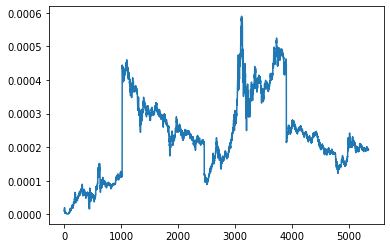

In [8]:
index = df.index
df.reset_index(drop=True, inplace=True)
X = df.loc[:, df.columns != "open"]
y = df.loc[:, df.columns == "open"]
plt.plot(y)

### Configuration

In [9]:
class config:
    BATCH_SIZE_TRAIN = 16
    BATCH_SIZE_VALIDATION = 8
    BATCH_SIZE_TEST = 8
    DROPOUT = 0.2
    EPOCHS = 50
    FOLDS = 10
    HIDDEN_DIM = 64
    LAYER_DIM = 3
    LEARNING_RATE = 1e-3
    LR_FACTOR = 0.4  # BY HOW MUCH THE LR IS DECREASING
    LR_PATIENCE = 1  # 1 MODEL NOT IMPROVING UNTIL LR IS DECREASING
    OUTPUT_DIM = 1
    WEIGHT_DECAY = 1e-6

# RNN model

In [10]:
class RNNModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, layer_dim, output_dim, dropout_prob, device):
        super(RNNModel, self).__init__()

        # Defining the number of layers and the nodes in each layer
        self.hidden_dim = hidden_dim
        self.layer_dim = layer_dim

        # RNN layers
        self.rnn = nn.RNN(
            input_dim, hidden_dim, layer_dim, batch_first=True, dropout=dropout_prob
        )
        # Fully connected layer
        self.fc = nn.Linear(hidden_dim, output_dim)
        self.device = device

    def forward(self, x):
        # Initializing hidden state for first input with zeros
        h0 = torch.zeros(self.layer_dim, x.size(0), self.hidden_dim).requires_grad_().to(device)

        # Forward propagation by passing in the input and hidden state into the model
        out, h0 = self.rnn(x, h0.detach())

        # Reshaping the outputs in the shape of (batch_size, seq_length, hidden_size)
        # so that it can fit into the fully connected layer
        out = out[:, -1, :]

        # Convert the final state to our desired output shape (batch_size, output_dim)
        out = self.fc(out)
        return out

# LSTM model

In [11]:
class LSTMModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, layer_dim, output_dim, dropout_prob, device):
        super(LSTMModel, self).__init__()

        # Defining the number of layers and the nodes in each layer
        self.hidden_dim = hidden_dim
        self.layer_dim = layer_dim

        # LSTM layers
        self.lstm = nn.LSTM(
            input_dim, hidden_dim, layer_dim, batch_first=True, dropout=dropout_prob
        )

        # Fully connected layer
        self.fc = nn.Linear(hidden_dim, output_dim)
        self.device = device

    def forward(self, x):
        # Initializing hidden state for first input with zeros
        h0 = torch.zeros(self.layer_dim, x.size(0), self.hidden_dim).requires_grad_().to(device)

        # Initializing cell state for first input with zeros
        c0 = torch.zeros(self.layer_dim, x.size(0), self.hidden_dim).requires_grad_().to(device)

        # We need to detach as we are doing truncated backpropagation through time (BPTT)
        # If we don't, we'll backprop all the way to the start even after going through another batch
        # Forward propagation by passing in the input, hidden state, and cell state into the model
        out, (hn, cn) = self.lstm(x, (h0.detach(), c0.detach()))

        # Reshaping the outputs in the shape of (batch_size, seq_length, hidden_size)
        # so that it can fit into the fully connected layer
        out = out[:, -1, :]

        # Convert the final state to our desired output shape (batch_size, output_dim)
        out = self.fc(out)

        return out

# GRU model

In [12]:
class GRUModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, layer_dim, output_dim, dropout_prob):
        super(GRUModel, self).__init__()

        # Defining the number of layers and the nodes in each layer
        self.layer_dim = layer_dim
        self.hidden_dim = hidden_dim

        # GRU layers
        self.gru = nn.GRU(
            input_dim, hidden_dim, layer_dim, batch_first=True, dropout=dropout_prob
        )

        # Fully connected layer
        self.fc = nn.Linear(hidden_dim, output_dim)
        self.device = device

    def forward(self, x):
        # Initializing hidden state for first input with zeros
        h0 = torch.zeros(self.layer_dim, x.size(0), self.hidden_dim).requires_grad_().to(device)

        # Forward propagation by passing in the input and hidden state into the model
        out, _ = self.gru(x, h0.detach()).to(device)

        # Reshaping the outputs in the shape of (batch_size, seq_length, hidden_size)
        # so that it can fit into the fully connected layer
        out = out[:, -1, :]

        # Convert the final state to our desired output shape (batch_size, output_dim)
        out = self.fc(out)

        return out

### Select model

In [13]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def get_model(model, model_params):
    models = {
        "rnn": RNNModel,
        "lstm": LSTMModel,
        "gru": GRUModel,
    }
    return models.get(model.lower())(**model_params)


model_params = {'input_dim': len(X.columns),
                'hidden_dim' : config.HIDDEN_DIM,
                'layer_dim' : config.LAYER_DIM,
                'output_dim' : config.OUTPUT_DIM,
                'dropout_prob' : config.DROPOUT,
                'device': device}

model = get_model('lstm', model_params)
model = model.to(device)

### Select scaler

In [14]:
def get_scaler(scaler):
    scalers = {
        "minmax": MinMaxScaler(),
        "standard": StandardScaler,
        "maxabs": MaxAbsScaler,
        "robust": RobustScaler(),
    }
    return scalers.get(scaler.lower())

scaler = get_scaler('minmax')

# Time Series Split

In a time series split you want to make sure that none of the information about the future is fed into your model to give it observations about something it shouldn't have seen at that moment in time. It also is known as a sliding window approach where you grow the amount of training data that you're providing it in time and then testing on the amount of time right after the training period ends.

In [15]:
from sklearn.model_selection import TimeSeriesSplit

tss = TimeSeriesSplit(n_splits=config.FOLDS, max_train_size=None, test_size=None, gap=0)

# Train function

In [16]:
def train_function(X, y, model, tss):
    
    # Out of Fold Predictions
    oof = []
    y_trues = []
    # Define MinMaxScaler()
    scaler = get_scaler("minmax")
    train_losses = []
    validation_losses = []
    
    for train_index, valid_index in tss.split(X):
        # Initiate the model
        model = model
        
        # Create optimizer. Check ReadMe.md for more information.
        optimizer = torch.optim.Adam(model.parameters(),
                               lr=config.LEARNING_RATE,
                               weight_decay=config.WEIGHT_DECAY)
        
        # Create scheduler. Check ReadMe.md for more information.
        scheduler = ReduceLROnPlateau(optimizer=optimizer,
                                      mode='max',
                                      patience=config.LR_PATIENCE,
                                      verbose=False,
                                      factor=config.LR_FACTOR)
        
        # Create Loss. Check ReadMe.md for more information.
        criterion = nn.MSELoss(reduction="mean")
        
        print("Train size:", len(train_index), "Test size:", len(valid_index)), print("\n")
        X_train, X_valid = X.iloc[train_index], X.iloc[valid_index]
        y_train, y_valid = y.iloc[train_index], y.iloc[valid_index]
        
        # Scale features
        X_train = scaler.fit_transform(X_train)
        X_valid = scaler.transform(X_valid)
        y_train = scaler.fit_transform(y_train)
        y_valid = scaler.transform(y_valid)

        X_train = torch.Tensor(X_train)
        X_valid = torch.Tensor(X_valid)
        y_train = torch.Tensor(y_train)
        y_valid = torch.Tensor(y_valid)

        train = TensorDataset(X_train, y_train)
        val = TensorDataset(X_valid, y_valid)

        train_loader = DataLoader(train,
                                  batch_size=config.BATCH_SIZE_TRAIN,
                                  shuffle=False,
                                  drop_last=True)
        val_loader = DataLoader(val,
                                batch_size=config.BATCH_SIZE_VALIDATION,
                                shuffle=False,
                                drop_last=True)
        
        # === EPOCHS ===
        epochs = config.EPOCHS
        for epoch in range(epochs):
            batch_train_losses = []
            batch_val_losses = []
            start_time = time.time()

            # === TRAIN ===
            # Sets the module in training mode.
            model.train()
            
            # === Iterate over batches ===
            for x_train_batch, y_train_batch in train_loader:
                x_train_batch = x_train_batch.view([config.BATCH_SIZE_TRAIN, -1, model_params["input_dim"]]).to(device)
                y_true = y_train_batch.to(device)
                # Clear gradients first; very important, usually done BEFORE prediction
                optimizer.zero_grad()
                # Log Probabilities & Backpropagation
                y_pred = model(x_train_batch)
                loss = criterion(y_true, y_pred)
                loss.backward()
                optimizer.step()
                batch_train_losses.append(loss.item())
                    
            training_loss = np.mean(batch_train_losses)
            train_losses.append(training_loss)

            # === EVAL ===
            # Sets the model in evaluation mode
            model.eval()
            # Disables gradients (we need to be sure no optimization happens)
            with torch.no_grad():
                for x_val, y_val in val_loader:
                    x_val = x_val.view([config.BATCH_SIZE_VALIDATION, -1, model_params["input_dim"]]).to(device)
                    y_true = y_val.to(device)
                    y_pred = model(x_val)
                    val_loss = criterion(y_true, y_pred).item()
                    batch_val_losses.append(val_loss)
                validation_loss = np.mean(batch_val_losses)
                validation_losses.append(validation_loss)
                
            # Compute time on Train + Eval
            duration = str(datetime.timedelta(seconds=time.time() - start_time))[:7]
                
            # Print status
            if (epoch <= 10) | (epoch % 50 == 0):
                print(
                    f"[{epoch}/{epochs}] Training loss: {training_loss:.4f}\t Validation loss: {validation_loss:.4f}"
                )
            # Update scheduler (for learning_rate)
            scheduler.step(validation_loss)
        
        # === Out of Fold predictions ===
        # Sets the model in evaluation mode
        model.eval()
        with torch.no_grad():
            for x_val, y_val in val_loader:
                x_val = x_val.view([config.BATCH_SIZE_VALIDATION, -1, model_params["input_dim"]]).to(device)
                y_true = y_val.to(device)
                y_pred = model(x_val)
                oof.append(scaler.inverse_transform(y_pred.cpu().numpy()))
        y_trues.append(scaler.inverse_transform(y_valid.cpu().numpy()))

    return train_losses, validation_losses, oof, y_trues

# Train

In [17]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Current device: {device}")

train_losses, validation_losses, oof, y_trues = train_function(X, y, model, tss)

Current device: cuda
Train size: 490 Test size: 485


[0/50] Training loss: 0.1484	 Validation loss: 0.2275
[1/50] Training loss: 0.0351	 Validation loss: 0.1055
[2/50] Training loss: 0.0537	 Validation loss: 0.0468
[3/50] Training loss: 0.0320	 Validation loss: 0.0882
[4/50] Training loss: 0.0258	 Validation loss: 0.0789
[5/50] Training loss: 0.0217	 Validation loss: 0.0784
[6/50] Training loss: 0.0204	 Validation loss: 0.0782
[7/50] Training loss: 0.0190	 Validation loss: 0.0777
[8/50] Training loss: 0.0193	 Validation loss: 0.0765
[9/50] Training loss: 0.0183	 Validation loss: 0.0765
[10/50] Training loss: 0.0181	 Validation loss: 0.0763
Train size: 975 Test size: 485


[0/50] Training loss: 0.0151	 Validation loss: 2.2393
[1/50] Training loss: 0.0098	 Validation loss: 2.0996
[2/50] Training loss: 0.0093	 Validation loss: 2.1870
[3/50] Training loss: 0.0073	 Validation loss: 2.0466
[4/50] Training loss: 0.0057	 Validation loss: 1.9569
[5/50] Training loss: 0.0053	 Validation loss: 1

### Plot

In [18]:
def plot_losses(train_losses, validation_losses):
    plt.plot(train_losses, label="Training loss")
    plt.plot(validation_losses, label="Validation loss")
    plt.legend()
    plt.title("Losses")
    plt.show()
    plt.close()
    

def plot_oof(ground_truth, oof):
    plt.plot(ground_truth, label="Ground truth")
    plt.plot(oof, label="OOF")
    plt.legend()
    plt.title("Out of Fold vs. Ground truth")
    plt.show()
    plt.close()
    
    
def unstack(oof):
    preds = []
    for batch_prediction in oof:
        preds.append(batch_prediction.tolist())
    preds = [item for sublist in preds for item in sublist]
    preds = [item for sublist in preds for item in sublist]
    return preds


oof = unstack(oof)
y_trues = unstack(y_trues)


### Plot Losses

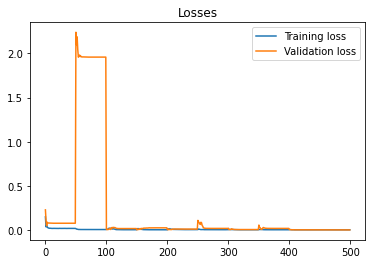

In [19]:
plot_losses(train_losses, validation_losses)

### Plot OOF predictions (Matplotlib)

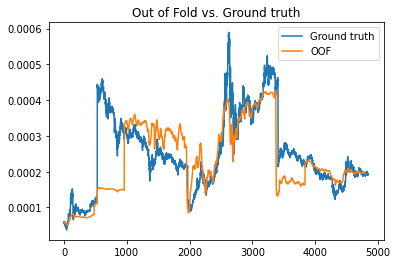

In [20]:
plot_oof(y_trues , oof)

# Plot OOF predictions (Plotly)

In [21]:
import plotly.express as px
import plotly.graph_objects as go

plot_df = pd.DataFrame([oof, y_trues]).T
plot_df.columns = ["oof","y_true"]
plot_df["date"] = index[0:4850]
plot_df = plot_df[0:4800]
plot_df.sort_values(by="date",inplace=True)

fig = go.Figure()

fig1 = fig.add_trace(
    go.Scatter(
        x = plot_df["date"],
        y = plot_df["oof"],
        name = "Predicted", # LINE LEGEND
        marker=dict(color="#eb9607"), # LINE COLOR
    )
)
fig2 = fig.add_trace(
    go.Scatter(
        x = plot_df["date"],
        y = plot_df["y_true"],
        name = "Actual", # LINE LEGEND
        marker=dict(color="#ecc257"), # LINE COLOR
    )
)

fig.update_layout(
    title_text="Predicted vs Actual Luna Price",
    template="plotly_dark",
    title_font_color="#cf7200", # TITLE FONT COLOR
    xaxis=dict(color="#cf7200"), # X AXIS COLOR
    yaxis=dict(color="#cf7200") # Y AXIS COLOR
)
fig.show()